In [3]:
#input two inspiration and expiration image
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

import sys
reload(sys)
sys.setdefaultencoding('utf8')
import SimpleITK as sitk

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

ImportError: cannot import name 'NUMPY_MKL'

In [2]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [4]:
#input two inspiration and expiration image

insPath = '/media/duan/影像资料/CT/010_XIN_HAI_TANG_CT161025013/THORAX_WKLUNGLOWDOSE_(ADULT)_20161025_091243_966000/LUNGLOWDOSEIN_1_0_B31F_0005'
exPath = '/media/duan/影像资料/CT/010_XIN_HAI_TANG_CT161025013/THORAX_WKLUNGLOWDOSE_(ADULT)_20161025_091243_966000/LUNGLOWDOSEE_1_0_B31F_0010'
ins = load_scan(insPath)
insPixels = get_pixels_hu(ins)
ex = load_scan(exPath)
exPixels = get_pixels_hu(ex)

In [5]:
# Resampling

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image

In [6]:
insPixels = resample(insPixels, ins, [1,1,1])
exPixels = resample(exPixels, ex, [1, 1, 1])

In [7]:
print (insPixels.shape)
print (exPixels.shape)

In [5]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [6]:
insmask = segment_lung_mask(insPixels, True)

exmask = segment_lung_mask(exPixels, True)

In [7]:
import numpy
insImage = sitk.GetImageFromArray(insPixels)
exImage = sitk.GetImageFromArray(exPixels)
insmask = numpy.array(insmask, dtype=numpy.uint8)
exmask = numpy.array(exmask, dtype=numpy.uint8)
insmaskImage = sitk.GetImageFromArray(insmask)
exmaskImage = sitk.GetImageFromArray(exmask)

In [8]:
import SimpleITK
import scipy.misc
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    nda = scipy.misc.imrotate(nda,180)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

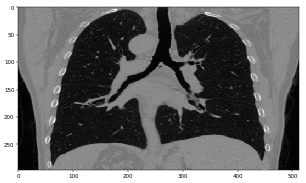

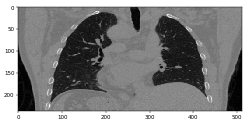

In [9]:
inSlice = insImage[: ,250,:]
exSlice = exImage[:,250,:]
sitk_show(inSlice)
sitk_show(exSlice)

In [ ]:
insImage[inSlice <-950] = 1;
insImage[inSlice >-950] = 0;


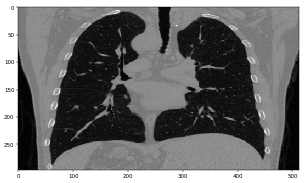

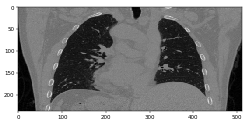

In [52]:
inSlice = insImage[: ,240,:]
exSlice = exImage[:,240,:]
sitk_show(inSlice)
sitk_show(exSlice)

In [60]:
import SimpleITK as sitk

movingMask = sitk.Cast(insmaskImage, sitk.sitkUInt8)
movingMask = sitk.Cast(exmaskImage, sitk.sitkUInt8)

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(inSlice)
elastixImageFilter.SetMovingImage(exSlice)
elastixImageFilter.SetFixedMask(insmaskImage[:,240,:])
elastixImageFilter.SetMovingMask(exmaskImage[:,240,:])
parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
elastixImageFilter.SetParameterMap(parameterMapVector)

elastixImageFilter.Execute()
exTransform = elastixImageFilter.GetResultImage()

RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /home/duan/Developer/SImpleEla/SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:208:
sitk::ERROR: 
itk::ExceptionObject (0xb640ef0)
Location: "unknown" 
File: /home/duan/Developer/SImpleEla/build/Elastix/src/Core/Main/elxElastixFilter.hxx
Line: 240
Description: itk::ERROR: Self(0x3fee72c0): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



In [ ]:
import SimpleITK as sitk

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(insImage)
elastixImageFilter.SetMovingImage(exImage)
parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
elastixImageFilter.SetParameterMap(parameterMapVector)

elastixImageFilter.Execute()
exTransform = elastixImageFilter.GetResultImage()

In [61]:
import sys
spacing = exTransform.GetSpacing()
exTransArray = SimpleITK.GetArrayFromImage(exTransform)
print (spacing)
print (exTransArray.shape)

In [58]:
sitk.WriteImage(exTransform, '/home/duan/exTransform.mhd')

In [59]:
sitk.WriteImage(exImage, '/home/duan/exImage.mhd')

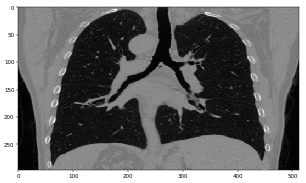

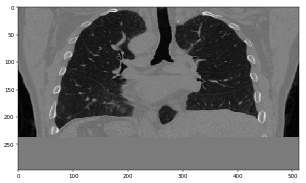

In [62]:
inSlice = insImage[: ,250,:]
exSlice = exTransform[:,250,:]
sitk_show(inSlice)
sitk_show(exSlice)

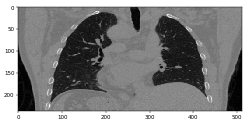

In [63]:
sitk_show(exImage[:,250,:])

In [75]:
print (insmask.nbytes)

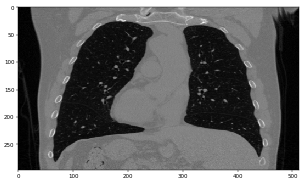

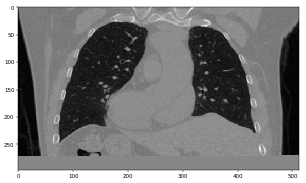

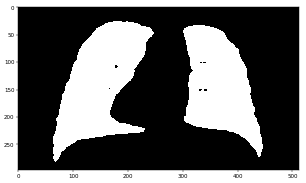

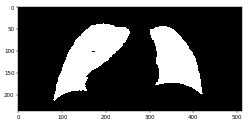

In [84]:
inSlice = insImage[: ,200,:]
exSlice = exTransform[:,200,:]
sitk_show(inSlice)
sitk_show(exSlice)
sitk_show(insmaskImage[:,200,:])
sitk_show(exmaskImage[:,200,:])

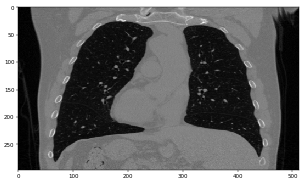

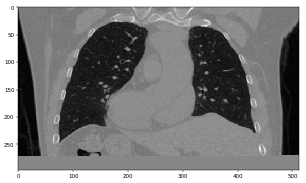

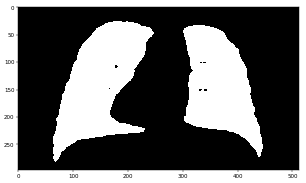

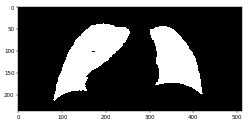

In [92]:
inSlice = insImage[: ,200,:]
exSlice = exTransform[:,200,:]
sitk_show(inSlice)
sitk_show(exSlice)
sitk_show(insmaskImage[:,200,:])
sitk_show(exmaskImage[:,200,:])

In [ ]:
# Registration With New Parameter

# Set fix and moving image

import SimpleITK as sitk

movingMask = sitk.Cast(insmaskImage, sitk.sitkUInt8)
movingMask = sitk.Cast(exmaskImage, sitk.sitkUInt8)

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(insImage)
elastixImageFilter.SetMovingImage(exImage)
elastixImageFilter.SetFixedMask(insmaskImage)
elastixImageFilter.SetMovingMask(exmaskImage)


#input parametermap
affineParameterMap= sitk.ElastixImageFilter().ReadParameterFile('/home/duan/Data/affineParameterMap1.txt')
DeformalParameterMap = sitk.ElastixImageFilter().ReadParameterFile('/home/duan/Data/DeformalParameterMap1.txt')

parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(affineParameterMap)
parameterMapVector.append(DeformalParameterMap)
elastixImageFilter.SetParameterMap(parameterMapVector)

elastixImageFilter.Execute()
exTransform = elastixImageFilter.GetResultImage()

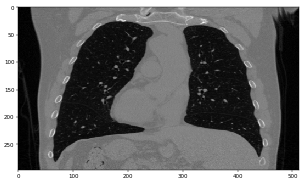

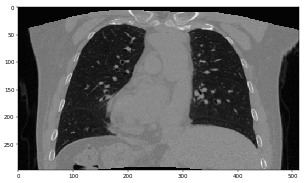

In [95]:
inSlice = insImage[: ,200,:]
exSlice = exTransform[:,200,:]
sitk_show(inSlice)
sitk_show(exSlice)

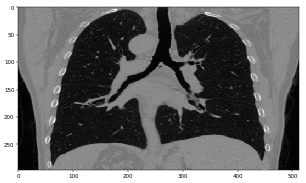

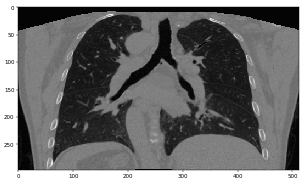

In [96]:
inSlice = insImage[: ,250,:]
exSlice = exTransform[:,250,:]
sitk_show(inSlice)
sitk_show(exSlice)

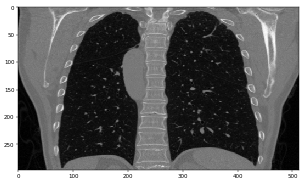

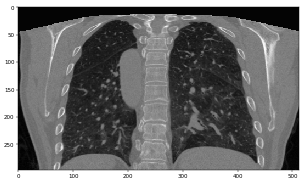

In [97]:
inSlice = insImage[: ,300,:]
exSlice = exTransform[:,300,:]
sitk_show(inSlice)
sitk_show(exSlice)

In [98]:
import SimpleITK as sitk

movingMask = sitk.Cast(insmaskImage, sitk.sitkUInt8)
movingMask = sitk.Cast(exmaskImage, sitk.sitkUInt8)

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(insImage)
elastixImageFilter.SetMovingImage(exImage)
elastixImageFilter.SetFixedMask(insmaskImage)
elastixImageFilter.SetMovingMask(exmaskImage)


#input parametermap
affineParameterMap= sitk.ElastixImageFilter().ReadParameterFile('/home/duan/Data/affineParameterMap.txt')
DeformalParameterMap = sitk.ElastixImageFilter().ReadParameterFile('/home/duan/Data/DeformalParameterMap1.txt')

parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(affineParameterMap)
parameterMapVector.append(DeformalParameterMap)
elastixImageFilter.SetParameterMap(parameterMapVector)

elastixImageFilter.Execute()
exTransform = elastixImageFilter.GetResultImage()

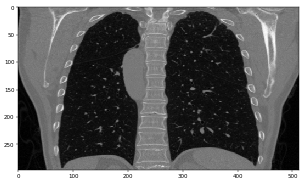

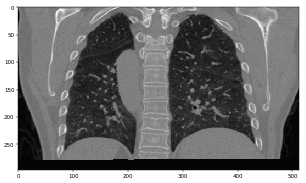

In [99]:
inSlice = insImage[: ,300,:]
exSlice = exTransform[:,300,:]
sitk_show(inSlice)
sitk_show(exSlice)

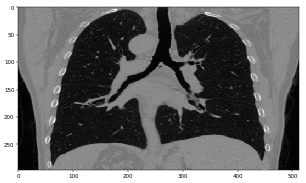

In [61]:
inSlice = insImage[:,250,:]
sitk_show(inSlice)
exTransform = SimpleITK.ReadImage('/home/duan/exTransform.mhd')
exSlice = exTransform[:,250,:]

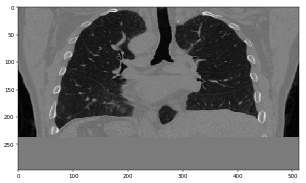

In [62]:
sitk_show(exSlice)